In [169]:
# RelaxationTestJ
# Created to test the relaxation method for a 3D rectangular lattice 
# and various features of NumPy. Jupyter Notebook Version
# made by Masen Pitts
# Updated 11/29/2021

import time
import numpy as np

# Addressing Possible Ambiguities in Comments:
# - "Boundary of the region" refers to the actual ends of the 3D mesh grid
# and not the points within the region that are given pre-determined values.
# - "Not Free Points" refers to points both on the boundary and within the boundary
# at which the value of the potential is pre-determined.


meshResolution = 40 # Gives the number of mesh points extending in each direction;
                    # each spatial axis has points defined on [0, meshResolution]
                    # (unless it is indicated otherwise)
 
# Function that sets the potential value of the mesh points on the boundary of the region and marks them
# as not free.
# Expected Parameters:
#   potential - A 3D NumPy Array of floating point values
#   freePoints - A 3D NumPy Array of boolean values
#   boundaryValue - A floating point or integer value specifying the desired value
#   of the potential at the boundary of the region
#**NOTE: This function expects "potential" and "freePoints" to be the same shape!**
def setBoundaries(potential, freePoints, boundaryValue):
    # Prints an error message and ends the program if the arrays passed to the function are not the same shape
    if potential.shape != freePoints.shape:
        print("Error: The array passed for the potential must be the same shape as the array passed for freePoints!")
        print("Check the shapes of the arrays being passed to the \"setBoundaries\" function")
        quit()   
    # Variables that store the values of the non-zero ends of the region boundary
    global xEnd, yEnd, zEnd
    xEnd = potential.shape[0]
    yEnd = potential.shape[1]
    zEnd = potential.shape[2]
    
    # Iterates through every mesh point on the boundary of the region, setting the potential
    # at these points equal to the given value and marking the points as not free
    for y in range(yEnd):
        for z in range(zEnd):
            potential[0, y, z] = boundaryValue
            potential[xEnd-1, y, z] = boundaryValue
            freePoints[0, y, z] = False
            freePoints[xEnd-1, y, z] = False
    for x in range(xEnd):
        for z in range(zEnd):
            potential[x, 0, z] = boundaryValue
            potential[x, yEnd-1, z] = boundaryValue
            freePoints[x, 0, z] = False
            freePoints[x, yEnd-1, z] = False
    for x in range(xEnd):
        for y in range(yEnd):
            potential[x, y, 0] = boundaryValue
            potential[x, y, zEnd-1] = boundaryValue
            freePoints[x, y, 0] = False
            freePoints[x, y, zEnd-1] = False

# Function that implements the relaxation method for a given 3D mesh grid to calculate the electrostatic
# potential at each free point on the grid.
# Expected Parameters:
#   p - A 3D NumPy Array of floating point values representing the "potential" array
#   freePoints - A 3D NumPy Array of boolean values
#   tolerance - A floating point number that specifies how accurate the relaxation should
#   be and hence how long the method should run. The process will stop once the largest change
#   in a potential value between any two iterations is less than "tolerance."
#   relaxFactor - A floating point number or integer that allows for over-relaxation to be used 
#   if desired. 
#       relaxFactor = 1: Normal relaxation method implemented
#       relaxFactor > 1: Over-relaxation occcurs
#   Values between 1 and 2 should be used since a value of 2 or greater makes the method unstable. 
#   Values in the range of 1.5-1.8 seem to be the fastest. This may change based on the value of 
#   meshResolution and can vary with given problem conditions
def relaxation(p, freePoints, tolerance, relaxFactor):
    
    dVmax = 100 # Keeps track of the largest change in potential value between the previous iterations
                # and the current one.
    n=0 # Counts the total number of iterations the while loop makes (for use see commented out code below)
    while dVmax > tolerance:
        dVmax = 0
        for x in range(xEnd):
            for y in range(yEnd):
                for z in range(zEnd):
                    if freePoints[x, y, z]:
                        oldV = p[x, y, z] # Store the old potential value at this point
                        # Calculate the new potential at this point by taking the average of the potential
                        # values of all adjacent points.
                        newV = (1/6)*(p[x+1,y,z]+p[x-1,y,z]+p[x,y+1,z]+p[x,y-1,z]+p[x,y,z+1]+p[x,y,z-1])
                        dV = newV - oldV    # Store the change in potential value between iterations
                        # Checks for new dVmax
                        if abs(dV) > dVmax:
                            dVmax = abs(dV)
                        p[x, y, z] = oldV + dV*relaxFactor
        n+=1           # This commented out code can be used to test values of relaxFactor; the code will 
        print(dVmax)   # print the total number of times the relaxation method iterates and will print the
    print(n)           # value of dVmax calculated during each iteration. Printing the value of dVmax allows
                       # the user to determine whether the algorithm is converging.


# Rectangular Metal Pipe
# Compare to: Infinitely Long Rectangular Metal Pipe (Griffiths Chapter 3, Example 5)
#******************************************************************************
xFactor = 5 # Determines the length of the pipe in the x direction as a multiple
            # of the width of the pipe
            
# Variables that determine the rectangular bounds of the region
# in Cartesian Coordinates
ySize = 5
zSize = ySize
xSize = xFactor*ySize

# Variables stored for convience for initializing the arrays and performing
# iterative calculations on the mesh points
yMesh = meshResolution + 1
zMesh = yMesh
xMesh = xFactor*meshResolution + 1

# Variable that stores the actual space between each of the mesh points
d = ySize/meshResolution

# Initializes a 3D NumPy array of float values with a shape determined by the x/y/zMesh variables;
# Used to store calculated values of the electrostatic potential at each mesh point. Fill the array
# with 1 if you plan on populating the grid with a guess of the analytical solution. Otherwise
# fill it with 0.
potential = np.full((xMesh, yMesh, zMesh), 1, dtype=np.float64)

# Initializes a 3D NumPy array of boolean values with the same shape as the "potential" array;
# Used to determine which mesh points are "free." Free mesh points are points where the potential
# is to be determined. Points that are not free are those that are given fixed values in the set-up
# of the model.
freePoints = np.full((xMesh, yMesh, zMesh), True, dtype=np.bool_)

setBoundaries(potential, freePoints, 0)

# Sets the values of the potential on the x = 0 face of the pipe
# The current boundary condition is V(0,y,z) = y*z
for y in range(yMesh):
    yd = y*d
    for z in range(zMesh):
        yz = yd*z*d
        potential[0, y, z] = yz
        freePoints[0, y, z] = False

C1 = (4*ySize*zSize)/(np.pi*np.pi) # A stored constant used to help calculate both the rough guess for the numerical solution
                                   # and the actual values for the analytical solution
        
# Populate free mesh points with a very coarse guess of values based on part of the first term of the analytical solution
C2 = -np.pi*np.sqrt(1/ySize*ySize + 1/zSize*zSize) # Constant value stored for optimization
for x in range(xMesh):
    if freePoints[x].all() == True:
        potential[x] = C1*potential[x]*np.exp(C2*x*d)

# Execute the relaxation algorithm and time how long it takes to run
start = time.time()
relaxation(potential, freePoints, 0.01, 1.8)
print(time.time() - start)

8.635951450892856
7.815900205596804
4.766278313107776
2.9672889776317675
1.904370283407303
1.266523338500391
1.0887906136288081
0.8422606816666214
0.6755135787525393
0.5409651282508361
0.4528602900043328
0.3622653981890167
0.29786663020983895
0.24153087085445124
0.20050032745098667
0.16306247120442485
0.13481971188180086
0.11005247321916745
0.0915955587710724
0.07448519186839997
0.0620169173246472
0.050275099486355224
0.04194097437268196
0.03376820656304336
0.02815348821945074
0.022583562386072842
0.01984835103402871
0.018880738297419264
0.01802466578676981
0.017143448317461396
0.0163781501221838
0.015569640662587647
0.014876903943891295
0.014130068446999267
0.013496436273968515
0.012802677241928406
0.0122177765729094
0.011570604764289283
0.011026938384082197
0.010421363686409724
0.009921354193966225
41
48.07434439659119


In [24]:
# Initializes a 3D NumPy array of float values with the same shape as the "potential" and "freePoints" arrays;
# Used to store theoretical values of the electrostatic potential at each mesh point.
analytic = np.full((xMesh, yMesh, zMesh), 0, dtype=np.float64)

nlim = 10 # These determine how many terms of the infinite double series will be included in the summation. 
mlim = 10 # The total number of terms used in the calculation is nlim*mlim.

# Various constants stored to improve performance at each step of the process
piA = np.pi/ySize
piB = np.pi/zSize
a2 = ySize*ySize
b2 = zSize*zSize

# Calculate and store the theoretically predicted values of the potential inside of the pipe and time how
# long it takes to do this
start = time.time()

for x in range(xMesh):
    xpi = -x*d*np.pi
    for y in range(yMesh):
        piAY = piA*y*d
        for z in range(zMesh):
            piBZ = piB*z*d
            Sum = 0
            for n in range(nlim):
                n1 = n+1
                n2a2 = n1*n1/a2
                npiAY = n1*piAY
                for m in range(mlim):
                    m1 = m+1
                    expTerm = np.exp(xpi*np.sqrt(n2a2 + m1*m1/b2))
                    sinTerm = np.sin(npiAY)*np.sin(m1*piBZ)
                    # These statements address the fact that every term in the infinite double series is
                    # negative except for when n + m = (even integer). Using an if/else statement is faster
                    # than making two two np.power or math.pow function calls.
                    if (m1+n1) % 2 == 0:
                        Sum += (1/(n1*m1))*expTerm*sinTerm 
                    else:
                        Sum += -(1/(n1*m1))*expTerm*sinTerm
                        
            analytic[x,y,z] = Sum

analytic = C1*analytic # This finishes the calculation by multiplying every element in the array by the constant
                       # common to all terms. Doing this outside of the loop should save calculation time.

print(time.time() - start)

163.11151814460754


<IPython.core.display.Javascript object>


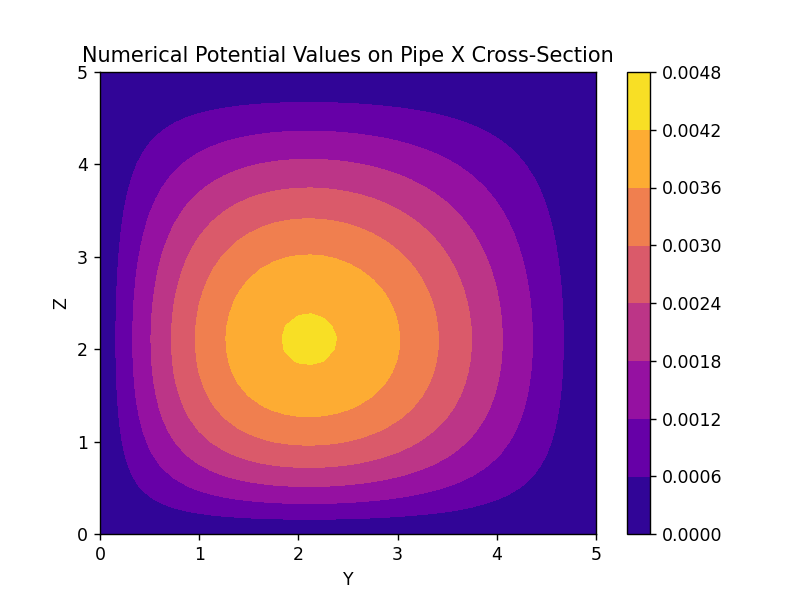

IntSlider(value=0, continuous_update=False, description='Mesh X', max=200)

<IPython.core.display.Javascript object>


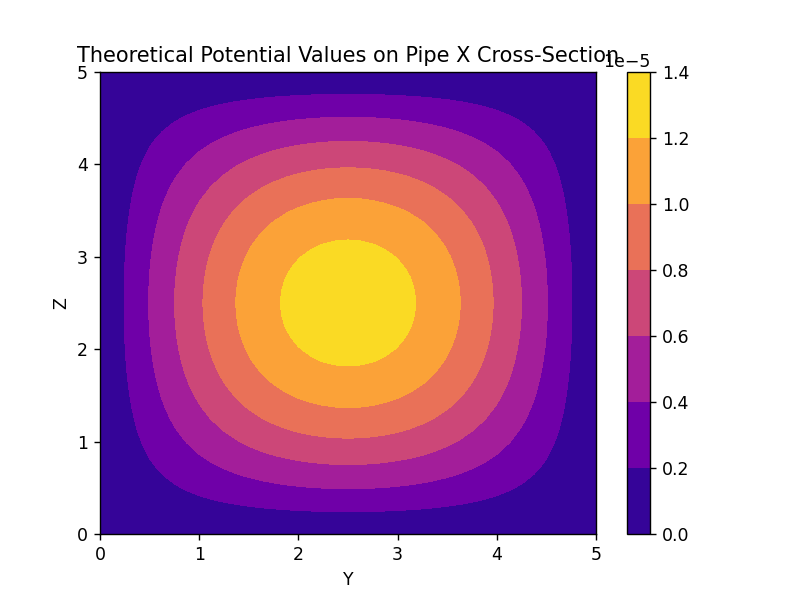

IntSlider(value=0, continuous_update=False, description='Mesh X', max=200)

<IPython.core.display.Javascript object>


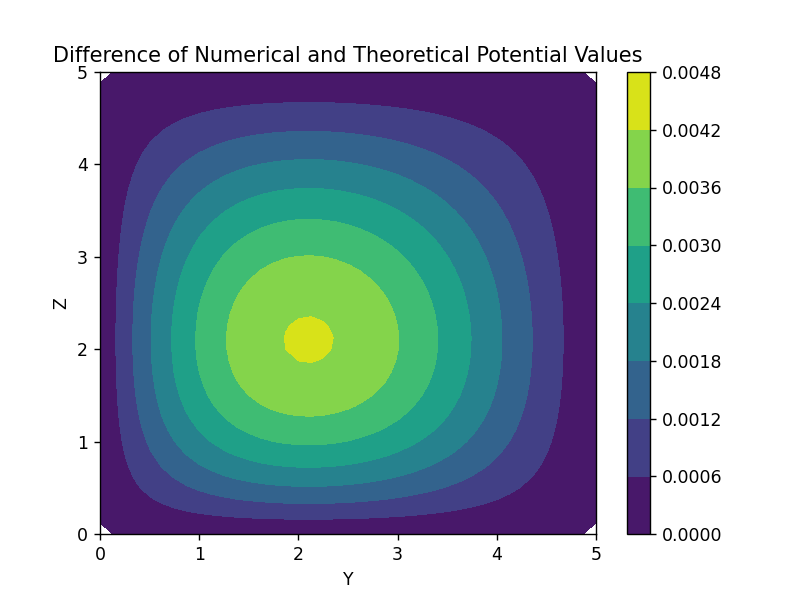

interactive(children=(IntSlider(value=0, continuous_update=False, description='Mesh X', max=200), Output()), _…

<function __main__.updateGraphs(slider)>

In [28]:
%matplotlib notebook
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import cm

# A NumPy array with the same shape and data type as the "potential" and "analytic" arrays that
# stores the difference of the values between corresponding entries of those arrays.
dataDiff = np.subtract(potential, analytic)

# Slider that controls the x-position of the pipe cross-section for both graphs
xSlider = widgets.IntSlider(value=0, min=0, max=xMesh-1, step=1, description="Mesh X", continuous_update=False)

'''
compare = plt.figure("Numerical and Theoretical Data")
fig, plots = plt.subplots(2)
display(xSlider)
pDiffplot = plt.figure("Difference")

# Create lists representing the y and z positions of the cross-section
y = np.linspace(0, ySize, yMesh)
z = np.linspace(0, zSize, zMesh)

def updateGraphs(slider):
    # Switch current figure to numerical one
    plt.figure("Numerical and Theoretical Data")
    compare.clear() # Clear the plot
    # Set graph attributes
    plots[0].set_title("Numerical Potential Values on Pipe X Cross-Section")
    plots[0].set_xlabel("Y")
    plots[0].set_ylabel("Z")
    plots[0].contourf(y, z, potential[slider], cmap=cm.coolwarm)
    
    plots[1].set_title("Theoretical Potential Values on Pipe X Cross-Section")
    plots[1].set_xlabel("Y")
    plots[1].set_ylabel("Z")
    plots[1].contourf(y, z, analytic[slider], cmap=cm.coolwarm)
    plt.colorbar()
    
    plt.figure("Difference")
    pDiffplot.clear()
    plt.title("Difference Between Theoretical and Numerical Potential Values")
    plt.xlabel("Y")
    plt.ylabel("Z")
    plt.contourf(y, z, percentDiff[slider], cmap=cm.coolwarm)
    plt.colorbar()
    
    plt.show()
'''    

# Set up the plots with the "figure" object
num = plt.figure("Numerical Solution") # Figure representing the numerical solution of the problem
display(xSlider)
ana = plt.figure("Analytical Solution") # Figure representing the analytical solution of the problem
display(xSlider)
diff = plt.figure("Data Difference") # Figure representing the difference between the numerical
                                             # and analytical solutions of the problem
# Create lists representing the y and z positions of the cross-section
y = np.linspace(0, ySize, yMesh)
z = np.linspace(0, zSize, zMesh)

# A function tied to the slider that updates the plots to correspond to the cross section
# at the position determined by the slider
def updateGraphs(slider):
    # Switch current figure to numerical one
    plt.figure("Numerical Solution")
    num.clear() # Clear the plot
    # Set graph attributes
    plt.title("Numerical Potential Values on Pipe X Cross-Section")
    plt.xlabel("Y")
    plt.ylabel("Z")
    # Plot data using the value of the slider to choose the cross-section
    plt.contourf(y, z, potential[slider], cmap=cm.plasma)
    plt.colorbar()
    # Switch current figure to analytical one
    plt.figure("Analytical Solution")
    ana.clear()
    plt.title("Theoretical Potential Values on Pipe X Cross-Section")
    plt.xlabel("Y")
    plt.ylabel("Z")
    plt.contourf(y, z, analytic[slider], cmap=cm.plasma)
    plt.colorbar()
    plt.show()
    # Switch current figure to difference plot
    plt.figure("Data Difference")
    diff.clear()
    plt.title("Difference of Numerical and Theoretical Potential Values")
    plt.xlabel("Y")
    plt.ylabel("Z")
    plt.contourf(y, z, dataDiff[slider], cmap=cm.viridis)
    plt.colorbar()
    plt.show()
    
# Create a widget that allows the graphs to be updated by the slider
widgets.interact(updateGraphs, slider=xSlider)
#******************************************************************************